In [97]:
from osgeo import gdal,ogr,osr
import os
import numpy as np
import matplotlib.pyplot as plt
#import spectral
#import rasterio
#import spectral.io.envi as envi
#import json
import math
from math import sqrt
import pandas as pd
import geopandas as gpd
import affine
from affine import Affine

In [64]:
file_dir = os.path.join(os.getcwd(),"file")

#input_dir = os.path.join(os.getcwd(),"input","clipped_img")
#file = os.path.join(input_dir,"clipped_img")
input_dir = os.path.join(os.getcwd(),"input","ang20180812t232708rfl")
file = os.path.join(input_dir,"ang20180812t232708_rfl_v2r2_img")
hdr_file = os.path.join(input_dir,"ang20180812t232708_rfl_v2r2_img.hdr")
output_dir = os.path.join(os.getcwd(),"output")

In [65]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	659
Rows (y-axis):	9426


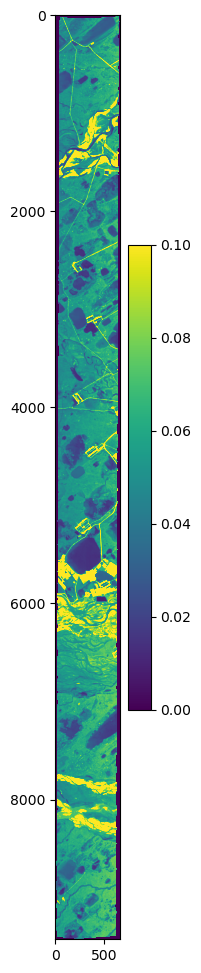

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [6]:
# Read header file and get the metadata
def read_envi_header(file_path):
    metadata = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if " = " in line:
                key, value = line.strip().split(" = ", 1)
                metadata[key.strip()] = value.strip().strip('{}')
            elif line.strip().endswith('}'):
                # Multi-line metadata
                key, value = lines[lines.index(line) - 1].strip().split(" = ", 1)
                metadata[key.strip()] += line.strip().strip('{}')
    return metadata

metadata = read_envi_header(hdr_file)
metadata

{'description': 'L2A Analytyical per-pixel surface retrieval',
 'samples': '659',
 'lines': '9426',
 'bands': '425',
 'header offset': '0',
 'file type': 'ENVI',
 'data type': '4',
 'interleave': 'bil',
 'byte order': '0',
 'map info': ' UTM , 1 , 1 , 418543.358108 , 7801905.49187 , 5.2 , 5.2 , 6 , North , WGS-84 , units=Meters , rotation=63.0000000 ',
 'radiance version': 'v2.0',
 'bad pixel map': '/home/jchapman/src/isat/ang/cal/data/ANGv5_bad',
 'flat field file': '/home/jchapman/src/isat/ang/cal/data/20180727_ang20180628_BLUSS_avg_rows300-340_ff',
 'rcc file': '/home/jchapman/src/isat/ang/cal/data/20180727_ang20180628_avg_rows300-340_UVCorr2.rcc',
 'spectral scatter file': '/home/jchapman/src/isat/ang/cal/data/20170125_via_ang20160925t182412_srf',
 'wavelength file': '/home/jchapman/src/isat/ang/cal/data/20170320_ang20170228_wavelength_fit_full.txt',
 'crosstrack scatter file': '/home/jchapman/src/isat/ang/cal/data/20170125_via_ang20160925t182412_crf',
 'wavelength': ' 376.85999999

In [66]:
map_info = metadata.get("map info")
print(f"Map info: {map_info}")

samples = metadata.get("samples")
print(f"Samples: {samples}")

wavelength = metadata.get("wavelength")
print(f"Wavelength: {wavelength}")

Map info:  UTM , 1 , 1 , 418543.358108 , 7801905.49187 , 5.2 , 5.2 , 6 , North , WGS-84 , units=Meters , rotation=63.0000000 
Samples: 659
Wavelength:  376.85999999999996 , 381.87 , 386.88 , 391.89000000000004 , 396.89000000000004 , 401.9 , 406.90999999999997 , 411.92 , 416.93 , 421.94 , 426.95 , 431.96000000000004 , 436.96000000000004 , 441.96999999999997 , 446.97999999999996 , 451.99 , 457.0 , 462.01 , 467.02 , 472.02 , 477.03000000000003 , 482.04 , 487.04999999999995 , 492.06 , 497.07 , 502.08 , 507.09000000000003 , 512.09 , 517.1 , 522.11 , 527.12 , 532.13 , 537.14 , 542.15 , 547.15 , 552.16 , 557.1700000000001 , 562.1800000000001 , 567.1899999999999 , 572.2 , 577.21 , 582.2199999999999 , 587.2199999999999 , 592.23 , 597.24 , 602.25 , 607.26 , 612.27 , 617.2800000000001 , 622.2800000000001 , 627.29 , 632.3 , 637.3100000000001 , 642.32 , 647.3299999999999 , 652.34 , 657.35 , 662.35 , 667.3599999999999 , 672.37 , 677.38 , 682.3900000000001 , 687.4 , 692.41 , 697.41 , 702.420000000000

In [67]:
# define plot site file path and read as a geopandas df
plot_site_input_dir = os.path.join(os.getcwd(),"input","32_Prudhoe_Bay_ARCSEES_Road_Study_0")
plot_site_file = os.path.join(plot_site_input_dir,"32_Prudhoe_Bay_ARCSEES_Road_Study_0.shp")
print(plot_site_file)

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
plot_sites = driver.Open(plot_site_file, 0)

plot_sites_geojson = gpd.read_file(plot_site_file)
plot_sites_geojson.head(5)

/Users/patrickangst/Documents/GitHub/UWW200_Master_Thesis_public/code/input/32_Prudhoe_Bay_ARCSEES_Road_Study_0/32_Prudhoe_Bay_ARCSEES_Road_Study_0.shp


,Turboveg_r,Field_rele,Modified_r,Date__year,Year_plot_,Dataset,Surveyed_b,lat,lon,System_for,Plant_comm,Habitat_Ty,Number_of_,Ancillary_,Cover_abun,image_url1,image_url2,image_url3,ObjectId,geometry
0,12763.0,T1-005-C,T1-005-C,20140807.0,2014.0,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22318,-148.4714,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,1.0,POINT (-16527761.536 11141746.889)
1,12764.0,T1-005-C,T1-005-T,20140807.0,2014.0,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22322,-148.4717,Field community name,"Wet Carex aquatilis, Drepanocladus brevifolius...","Wet nonacidic tundra (Carex spp., Eriophorum s...",None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,2.0,POINT (-16527791.325 11141759.934)
2,12765.0,T1-005-C,T1-010-C,20140806.0,2014.0,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22323,-148.4714,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,3.0,POINT (-16527756.115 11141762.115)
3,12766.0,T1-010-T,T1-010-T,20140806.0,2014.0,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22330,-148.4717,Field community name,"Wet Carex aquatilis, Drepanocladus brevifolius...","Wet nonacidic tundra (Carex spp., Eriophorum s...",None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,4.0,POINT (-16527796.969 11141784.658)
4,12767.0,T1-025-C,T1-025-C,20140806.0,2014.0,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22334,-148.4711,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,5.0,POINT (-16527726.971 11141797.407)


In [68]:


# Iterate using itertuples
for row in plot_sites_geojson.itertuples():
    print(f"Index: {row.Index}")
    print(f"Field_rele: {row.Field_rele}")
    print(f"Modified_r: {row.Modified_r}")
    print(f"Plant_comm: {row.Plant_comm}")
    print(f"Habitat_Ty: {row.Habitat_Ty}")
    print(f"Longitude: {row.lon}")
    print(f"Latitude: {row.lat}")
    print(f"geometry: {row.geometry}")
    print('---')


Index: 0
Field_rele: T1-005-C
Modified_r: T1-005-C
Plant_comm: Moist Carex aquatilis, Ochrolechia frigida graminoid meadow
Habitat_Ty: Moist nonacidic tundra (Sedge-Dryas-Tomentypnum communities)
Longitude: -148.4714
Latitude: 70.22318
geometry: POINT (-16527761.53592036 11141746.88898275)
---
Index: 1
Field_rele: T1-005-C
Modified_r: T1-005-T
Plant_comm: Wet Carex aquatilis, Drepanocladus brevifolius graminoid meadow
Habitat_Ty: Wet nonacidic tundra (Carex spp., Eriophorum spp.-Amblystegiaceae communities)
Longitude: -148.4717
Latitude: 70.22322
geometry: POINT (-16527791.3250161 11141759.93383984)
---
Index: 2
Field_rele: T1-005-C
Modified_r: T1-010-C
Plant_comm: Moist Carex aquatilis, Ochrolechia frigida graminoid meadow
Habitat_Ty: Moist nonacidic tundra (Sedge-Dryas-Tomentypnum communities)
Longitude: -148.4714
Latitude: 70.22323
geometry: POINT (-16527756.11466116 11141762.11511346)
---
Index: 3
Field_rele: T1-010-T
Modified_r: T1-010-T
Plant_comm: Wet Carex aquatilis, Drepanocla

In [112]:
# shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
lyr = plot_sites.GetLayer() # get the only layer in the shapefile
feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
geom = feat.GetGeometryRef()      # get the feature's geometry
geo_transform = img_open.GetGeoTransform() # get hyperspectral image geotransformation

# get transform for decimal degrees
from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
to_srs = osr.SpatialReference()                                        # init ogr srs object

to_srs.ImportFromEPSG(4326)                                            # import wgs84 srs def
xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object

# get UTM and lat/long coordinates for each of the sites
utm_coordinate_pairs = {}
ll_coordinate_pairs = {}
for feature in lyr:
    geometry = feature.GetGeometryRef()                                 # get site geometry
    utm_coordinate_pairs[feature['Modified_r']] = (geometry.GetX(), geometry.GetY()) # get x,y utm coordinates 
    geometry.Transform(xytransform)                                      # to wgs84
    ll_coordinate_pairs[feature['Modified_r']] = (geometry.GetX(), geometry.GetY())  # get lon, lat

   
# get the x and y UTM coordinates for the first site
# utm coordinates twisted in dataset
x, y = utm_coordinate_pairs['T1-010-C']

x_res = sqrt(geo_transform[1]*geo_transform[1] + geo_transform[2]*geo_transform[2])
y_res = sqrt(geo_transform[4]*geo_transform[4]+ geo_transform[5]*geo_transform[5])

print(f"x_res: {x_res}")
print(f"y_res: {y_res}")
geo_transform_new = (geo_transform[0],x_res,geo_transform[2],geo_transform[3],geo_transform[4],y_res)


# Create affine transformation matrix
affine_transform = Affine(
    geo_transform_new[1], geo_transform_new[2], geo_transform_new[0],
    geo_transform_new[4], geo_transform_new[5], geo_transform_new[3]
)


affine_transform = affine.Affine.from_gdal(*img_open.GetGeoTransform())     # affine forward transform
inverse_transform = ~affine_transform                                  # invert transform
px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers


# print the three coordinates (UTM, geographic, image)
print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
       " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['T1-005-C']),
       " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

x_res: 5.2
y_res: 5.2
Site 1 UTM coordinates (x,y): 				(-16527756.114661163, 11141762.115113463)
 are equal to geographic coordinates (lng,lat): 	(70.22317916, -148.47140799999997)
 and fall within image coordinates (pixel,line):	(-907235, -3195293)


In [102]:
geo_transform

(418543.358108,
 2.3607505986456436,
 4.633233925779513,
 7801905.49187,
 4.633233925779513,
 -2.3607505986456436)

In [110]:
def geo_to_pixel(x_geo, y_geo, GT):
    # Unpack geotransform parameters
    GT0, GT1, GT2, GT3, GT4, GT5 = GT

    # Calculate pixel and line coordinates
    # First, solve for y_line
    y_line = (y_geo - GT3 - GT4 * (x_geo - GT0) / GT1) / GT5

    # Then, solve for x_pixel
    x_pixel = (x_geo - GT0 - y_line * GT2) / GT1

    return x_pixel, y_line

# Define the geotransform parameters
GT = [418543.358108, 2.3607505986456436, 4.633233925779513, 7801905.49187, 4.633233925779513, -2.3607505986456436]

# Example geographic coordinates
x_geo = -16527761.535920363
y_geo = 11141746.888982747

# Compute pixel coordinates
x_pixel, y_line = geo_to_pixel(x_geo, y_geo, GT)

print(f"Pixel coordinates: ({x_pixel}, {y_line})")


Pixel coordinates: (23248096.571823493, -15503051.204402028)


In [ ]:
# Dictionary containing band descriptions
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# Function to classify bands based on their wavelength
def classify_band(wavelength):
    for region, limits in band_dictionary.items():
        if limits['lower'] < wavelength <= limits['upper']:
            return region
    return None

# define site on image
sitename1 = "Testsite 1"
px1, py1 = 600, 6000

sitename2 = "Testsite 2"
px2, py2 = 500, 5000

# Extracting metadata keys and values
metadata_keys = img_open.GetMetadata().keys()
metadata_values = img_open.GetMetadata().values()


# Lists of band numbers and band centers
band_numbers = [
    int(key.split("_")[1])
    for key in metadata_keys
    if key != "wavelength_units"
]

band_centers = [
    float(value.split(" ")[0])
    for value in metadata_values
    if value != "Nanometers"
]

# Classify each band center
em_regions = [classify_band(b) for b in band_centers]

def get_pixel_reflectance(x,y):
    return img_open.ReadAsArray(x,y,1,1).flatten().tolist()


# get the reflectance values of the site (careful: these values are already sorted --> add to df after sort)
#testsite1_reflectance = img_open.ReadAsArray(px1,py1,1,1).flatten().tolist()
#testsite2_reflectance = img_open.ReadAsArray(px2,py2,1,1).flatten().tolist()
testsite1_reflectance = get_pixel_reflectance(px1,py1)
testsite2_reflectance = get_pixel_reflectance(px2,py2)

reflectance_slow = [
    float(img_open.GetRasterBand(band_nr).ReadAsArray()[py,px])
    for band_nr in band_numbers
]

In [ ]:
# DataFrame describing bands
bands = pd.DataFrame({
    "Band number": band_numbers,
    "Band center (nm)": band_centers,
    "EM region": em_regions
}, index=band_numbers).sort_index()

bands[f"{sitename1} Reflectance"] = testsite1_reflectance
bands[f"{sitename2} Reflectance"] = testsite2_reflectance
print(bands.head(10))


In [ ]:
bands.tail

In [ ]:
bands.query("`Band number` == 57")

In [ ]:
fig, ax = plt.subplots()
ax.plot(bands["Band center (nm)"], bands["Testsite 1 Reflectance"], linewidth=1)
ax.plot(bands["Band center (nm)"], bands["Testsite 2 Reflectance"], linewidth=1)

x_limit_min = math.floor(bands["Band center (nm)"].min())
x_limit_max = math.ceil(bands["Band center (nm)"].max())

y_limit_min = bands[["Testsite 1 Reflectance","Testsite 2 Reflectance"]].min().min()
y_limit_max = bands[["Testsite 1 Reflectance","Testsite 2 Reflectance"]].max().max()

y_limit_min = -0.025
y_limit_max = 0.08

ax.set(xlim=(x_limit_min,x_limit_max), ylim=(y_limit_min,y_limit_max), xlabel="wavelength", ylabel="reflectance")

In [ ]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

# plot. all of this is matplotlib ---------->
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

bands.plot(x='Band center (nm)', y=f"{sitename1} Reflectance", 
            ax=ax1, c='black', label='_nolegend_', legend=False)
bands.plot(x='Band center (nm)', y=f"{sitename2} Reflectance", 
            ax=ax2, c='black', label='_nolegend_', legend=False)

for i, ax in enumerate([ax1,ax2]): 
    
    # add shaders for band regions
    for region,limits in band_dictionary.items():
        ax.axvspan(limits['lower'], limits['upper'], alpha=0.2, 
                   color=limits['color'], label=region)
        
    # add water vapor region shaders
    ax.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
    ax.axvspan(1790, 1955, alpha=0.1, color='blue')
    
    # some plotting config
    ax.set_ylim(0,0.1)
    ax.set_xlim(min(band_centers),max(band_centers))
    ax.set_ylabel("reflectance", fontsize=16)
    ax.set_xlabel("wavelength (nm)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid('on', alpha=0.25)
    ax.set_title("Test site "+str(i+1), fontdict = titlefont, pad = 10)

# now add custom legend
ax1.legend(prop={'size': 12}, loc = 'upper right', 
           bbox_to_anchor=(1, 1.2), ncol = 2, framealpha = 1)





In [ ]:
wavelengths = bands["Band center (nm)"]
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0

In [ ]:
px1_x, px1_y = 100, 6000
px2_x, px2_y = 250, 510

# Re-plot with the bad bands list and wavelengths applied
pixel1 = img_open.ReadAsArray(px1_x, px1_y, 1, 1)
pixel1 = np.reshape(pixel1,(425))

pixel2 = img_open.ReadAsArray(px2_x, px2_y, 1, 1)
pixel2 = np.reshape(pixel2,(425))

pixel1[bblist == 0] = np.nan
pixel2[bblist == 0] = np.nan


In [ ]:
min_pixel1 = np.nanmin(pixel1)
min_pixel2 = np.nanmin(pixel2)

if(min_pixel1 > min_pixel2):
    y_min = min_pixel2
else:
    y_min = min_pixel1

max_pixel1 = np.nanmax(pixel1)
max_pixel2 = np.nanmax(pixel2)

if(max_pixel1 > max_pixel2):
    y_max = max_pixel1
else:
    y_max = max_pixel2

print(y_min)
print(y_max)

In [ ]:
# Compare vegetation and water spectra
plt.plot(wavelengths, pixel1, color = 'g')
plt.plot(wavelengths, pixel2, color = 'b')
plt.xlabel ( 'Wavelength (nm)', fontsize=20)
#plt.ylim(y_min, y_max)
plt.ylabel('Reflectance', fontsize=20)
plt.grid()

plt.show()

In [ ]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(wavelengths, pixel1)
plt.plot(wavelengths, pixel2)


# add shaders for band regions
for region,limits in band_dictionary.items():
    plt.axvspan(limits['lower'], limits['upper'], alpha=0.2, color=limits['color'], label=region)
        
# add water vapor region shaders
plt.axvspan(1320, 1500, alpha=0.1, color='blue', label='water vapor regions')
plt.axvspan(1780, 2055, alpha=0.1, color='blue')
    
# some plotting config
#plt.ylim(y_min,y_max)
#plt.xlim(min(wavelengths),max(wavelengths))
plt.ylabel("reflectance", fontsize=16)
plt.xlabel("wavelength (nm)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid('on', alpha=0.25)
plt.title("Test sites", fontdict = titlefont, pad = 10)

# now add custom legend
plt.legend(prop={'size': 12}, loc = 'upper right', 
           bbox_to_anchor=(1, 1.25), ncol = 2, framealpha = 1)